# Chlorophyll-a Changes Over Time

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial import cKDTree
from scipy.stats import spearmanr
from scipy.signal import savgol_filter

import urllib.request
import datetime as dt

import netCDF4
from netCDF4 import Dataset, num2date

from matplotlib import pyplot as plt
%matplotlib inline

## Load the dataset from the csv file

In [2]:
df = pd.read_csv('RAW COMBINED DATA NEW.csv')

## Clean up and pivot the dataframe

In [3]:
df1 = df.drop(columns=['Depth','Latitude','Longitude','median','p5','p95','lowest','highest']).rename(columns={"mean": "Value"}).set_index(["Site Name", "Date"]).pivot(columns="Variable")['Value'].reset_index().rename_axis(None, axis=1)
df1

,Site Name,Date,Chl_a_sum,DIC,DIP,Kd_490,Oxygen,PAR,PH,SST,Salinity,Temp,Total_Nitrogen,WS_u,WS_v
0,Site A,2011-01-01,1.593400,23264.13033,4.593337,0.075506,6800.734121,0.000044,8.123843,26.472911,35.514774,21.548902,91.066483,-5.584072,1.927125
1,Site A,2011-02-01,1.178931,23201.26594,3.314823,0.066413,6949.013693,0.000050,8.113303,27.331098,35.478463,22.992727,80.496338,-3.962147,0.944716
2,Site A,2011-03-01,1.019666,23080.68346,4.986534,0.062134,6862.208664,0.000033,8.088158,27.078977,35.504641,24.553983,97.506236,-3.474723,1.007745
3,Site A,2011-04-01,1.118257,23121.66848,5.616589,0.069149,6644.618284,0.000026,8.090884,26.040695,35.438912,24.351538,101.215224,-4.370092,4.096774
4,Site A,2011-05-01,0.585132,23280.78416,1.851396,0.055997,6750.258710,0.000025,8.095257,24.170828,35.496033,23.837653,66.428991,0.448532,3.910924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Site E,2018-08-01,0.394180,23029.49614,1.258282,0.044661,6761.368262,0.000023,8.097806,25.130686,35.226449,24.860653,58.977623,-6.309957,5.065163
476,Site E,2018-09-01,0.376906,23099.83955,0.730994,0.043520,6775.243874,0.000036,8.091863,25.073075,35.252890,24.796843,53.927021,-7.234225,5.335747
477,Site E,2018-10-01,0.428957,23005.15362,0.425672,0.045482,6890.935002,0.000037,8.095646,25.778672,35.310891,24.984308,53.953252,-5.743962,3.482013
478,Site E,2018-11-01,0.532191,23007.50178,0.350171,0.049144,6891.067045,0.000053,8.083797,27.599377,35.268250,26.037196,53.595734,-4.367141,1.958173


## Create unique dataframes for each site

In [4]:
dfA = df1[(df1['Site Name'] == "Site A")]
dfB = df1[(df1['Site Name'] == "Site B")]
dfC = df1[(df1['Site Name'] == "Site C")]
dfD = df1[(df1['Site Name'] == "Site D")]
dfE = df1[(df1['Site Name'] == "Site E")]

## Convert dates to datetime

In [5]:
#Site A
idsA = np.arange(len(dfA))
dfA['ids'] = idsA
dfA["Date"] = pd.to_datetime(dfA["Date"])

#Site B
idsB = np.arange(len(dfB))
dfB['ids'] = idsB
dfB["Date"] = pd.to_datetime(dfB["Date"])

# Site C
idsC = np.arange(len(dfC))
dfC['ids'] = idsC
dfC["Date"] = pd.to_datetime(dfC["Date"])

# Site D
idsD = np.arange(len(dfD))
dfD['ids'] = idsD
dfD["Date"] = pd.to_datetime(dfD["Date"])

# Site E
idsE = np.arange(len(dfE))
dfE['ids'] = idsE
dfE["Date"] = pd.to_datetime(dfE["Date"])

/tmp/ipykernel_76/1834960262.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA['ids'] = idsA
/tmp/ipykernel_76/1834960262.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA["Date"] = pd.to_datetime(dfA["Date"])
/tmp/ipykernel_76/1834960262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

### Define x, y, trendline and rolling mean

In [6]:
#Site A
xA = dfA["ids"].values
yA = dfA["Chl_a_sum"].values
days = int(365*2)
rollingA = dfA.rolling(str(days) + "D", on="Date", min_periods=1).mean()
mA, bA = np.polyfit(xA, yA, 1)

#Site B
xB = dfB["ids"].values
yB = dfB["Chl_a_sum"].values
days = int(365*2)
rollingB = dfB.rolling(str(days) + "D", on="Date", min_periods=1).mean()
mB, bB = np.polyfit(xB, yB, 1)

#Site C
xC = dfC["ids"].values
yC = dfC["Chl_a_sum"].values
days = int(365*2)
rollingC = dfC.rolling(str(days) + "D", on="Date", min_periods=1).mean()
mC, bC = np.polyfit(xC, yC, 1)

# Site D
xD = dfD["ids"].values
yD = dfD["Chl_a_sum"].values
days = int(365*2)
rollingD = dfD.rolling(str(days) + "D", on="Date", min_periods=1).mean()
mD, bD = np.polyfit(xD, yD, 1)

# Site E
xE = dfE["ids"].values
yE = dfE["Chl_a_sum"].values
days = int(365*2)
rollingE = dfE.rolling(str(days) + "D", on="Date", min_periods=1).mean()
mE, bE = np.polyfit(xE, yE, 1)

## Plot monthly chlorophyll-a data with rolling mean and trendline

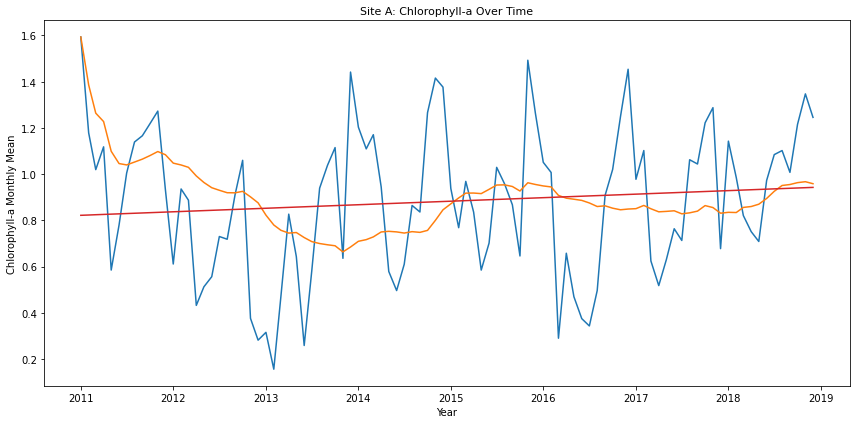

<Figure size 432x288 with 0 Axes>

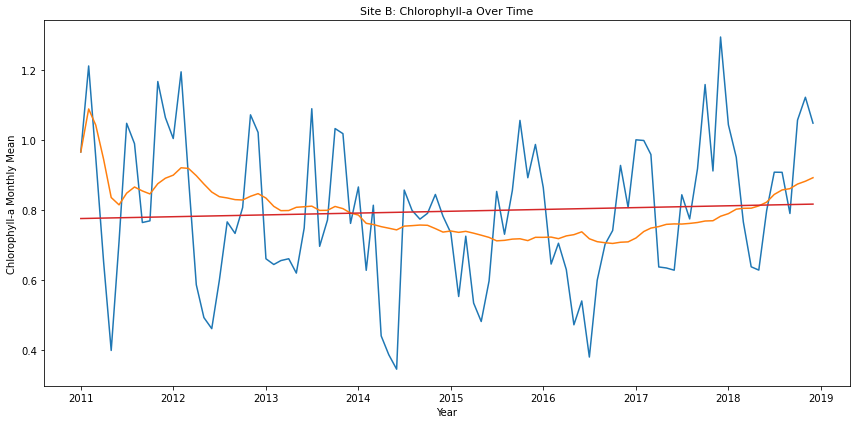

<Figure size 432x288 with 0 Axes>

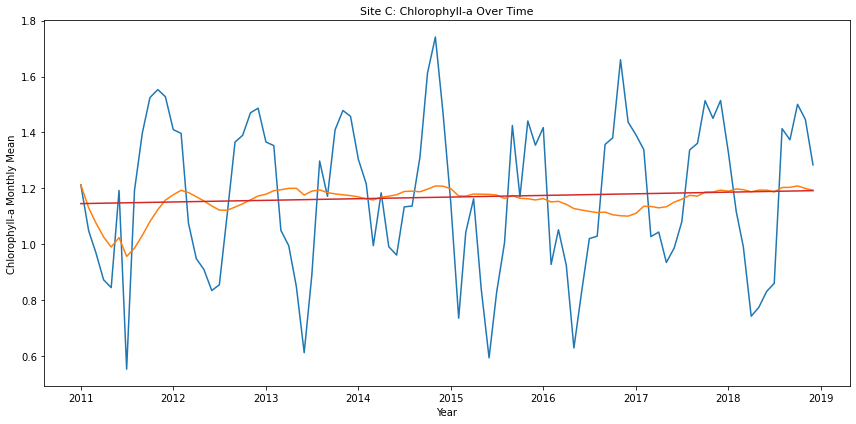

<Figure size 432x288 with 0 Axes>

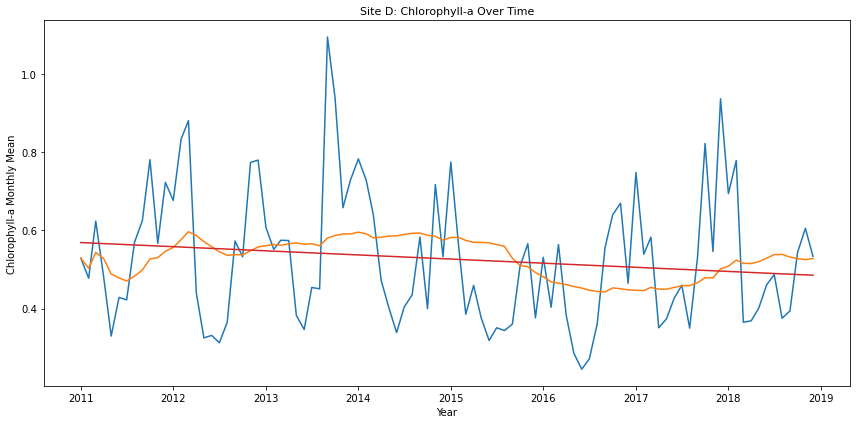

<Figure size 432x288 with 0 Axes>

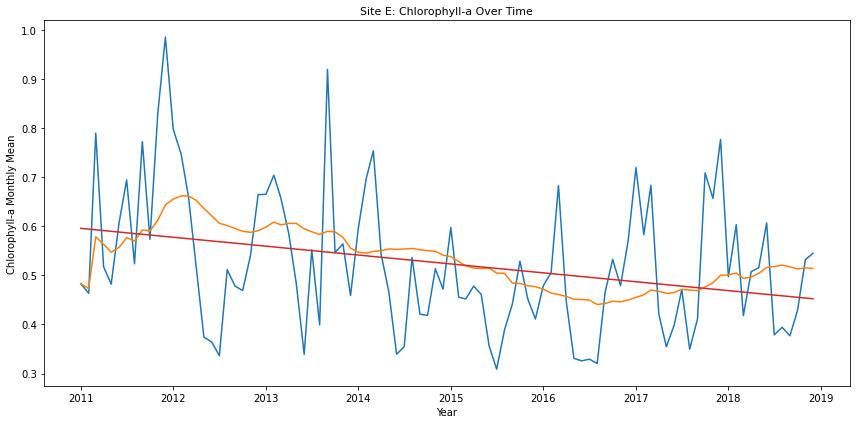

<Figure size 432x288 with 0 Axes>

In [7]:
#Site A

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Chlorophyll-a Monthly Mean')

ax1.plot(dfA["Date"],dfA["Chl_a_sum"], color='tab:blue') 
ax1.plot(rollingA["Date"],rollingA["Chl_a_sum"], color='tab:orange') 
ax1.plot(rollingA["Date"],mA*xA + bA, color='tab:red') 

plt.title('Site A: Chlorophyll-a Over Time',fontsize=11)
fig.tight_layout()

plt.show()
fig.clear()
plt.close(fig)
plt.clf()

#Site B

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Chlorophyll-a Monthly Mean')

ax1.plot(dfB["Date"],dfB["Chl_a_sum"], color='tab:blue') 
ax1.plot(rollingB["Date"],rollingB["Chl_a_sum"], color='tab:orange') 
ax1.plot(rollingB["Date"],mB*xB + bB, color='tab:red') 

plt.title('Site B: Chlorophyll-a Over Time',fontsize=11)
fig.tight_layout()

plt.show()
fig.clear()
plt.close(fig)
plt.clf()

#Site C

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Chlorophyll-a Monthly Mean')

ax1.plot(dfC["Date"],dfC["Chl_a_sum"], color='tab:blue') 
ax1.plot(rollingC["Date"],rollingC["Chl_a_sum"], color='tab:orange') 
ax1.plot(rollingC["Date"],mC*xC + bC, color='tab:red') 

plt.title('Site C: Chlorophyll-a Over Time',fontsize=11)
fig.tight_layout()

plt.show()
fig.clear()
plt.close(fig)
plt.clf()

#Site D

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Chlorophyll-a Monthly Mean')

ax1.plot(dfD["Date"],dfD["Chl_a_sum"], color='tab:blue') 
ax1.plot(rollingD["Date"],rollingD["Chl_a_sum"], color='tab:orange') 
ax1.plot(rollingD["Date"],mD*xD + bD, color='tab:red') 

plt.title('Site D: Chlorophyll-a Over Time',fontsize=11)
fig.tight_layout()

plt.show()
fig.clear()
plt.close(fig)
plt.clf()

#Site E

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Chlorophyll-a Monthly Mean')

ax1.plot(dfE["Date"],dfE["Chl_a_sum"], color='tab:blue') 
ax1.plot(rollingE["Date"],rollingE["Chl_a_sum"], color='tab:orange') 
ax1.plot(rollingE["Date"],mE*xE + bE, color='tab:red') 

plt.title('Site E: Chlorophyll-a Over Time',fontsize=11)
fig.tight_layout()

plt.show()
fig.clear()
plt.close(fig)
plt.clf()

# Site Comparison

### Define diff_ values by subtracting raw values from rolling mean

In [8]:
#Site A
diffA = (rollingA["Chl_a_sum"] - dfA["Chl_a_sum"])

#Site B
diffB = (rollingB["Chl_a_sum"] - dfB["Chl_a_sum"])

#Site C
diffC = (rollingC["Chl_a_sum"] - dfC["Chl_a_sum"])

#Site D
diffD = (rollingD["Chl_a_sum"] - dfD["Chl_a_sum"])

#Site E
diffE = (rollingE["Chl_a_sum"] - dfE["Chl_a_sum"])

### Define values for Savitzky–Golay smoothing filter

In [9]:
#Site A
xA = dfA["Date"]
yA = diffA
yA2 = savgol_filter(yA, 9, 3)

#Site B
xB = dfB["Date"]
yB = diffB
yB2 = savgol_filter(yB, 9, 3)

#Site C
xC = dfC["Date"]
yC = diffC
yC2 = savgol_filter(yC, 9, 3)

#Site D
xD = dfD["Date"]
yD = diffD
yD2 = savgol_filter(yD, 9, 3)

#Site E
xE = dfE["Date"]
yE = diffE
yE2 = savgol_filter(yE, 9, 3)

### Plot site diff values with smoothing filter

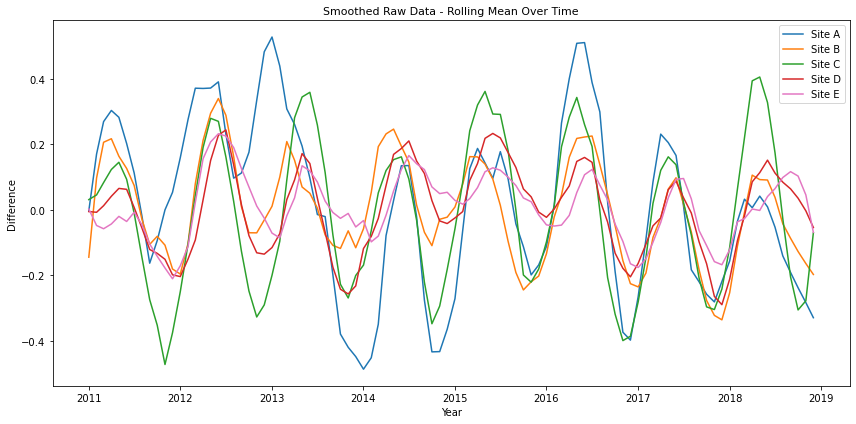

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.set_xlabel('Year')
ax1.set_ylabel('Difference')

ax1.plot(xA, yA2, color='tab:blue', label="Site A") 
ax1.plot(xB, yB2, color='tab:orange', label="Site B") 
ax1.plot(xC, yC2, color='tab:green', label="Site C") 
ax1.plot(xD, yD2, color='tab:red', label="Site D") 
ax1.plot(xE, yE2, color='tab:pink', label="Site E") 

plt.title('Smoothed Raw Data - Rolling Mean Over Time',fontsize=11)
plt.legend(loc="upper right")
fig.tight_layout()

plt.show()
fig.clear()
plt.close(fig)
plt.clf()